## Importing

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
from utils.utils import *
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN
import sympytorch


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
import random

def set_pytorch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True)
set_pytorch_seed(0)

## Utils

In [4]:
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE
from train_and_eval import eval_model
from datasets.SyntheticData import SyntheticData
from sympy import symbols, sin, summation, simplify
import networkx as nx
from torch_geometric.utils import from_networkx
from utils.utils import integrate
from torch_geometric.data import Data
from experiments.experiments_mpnn import activations
from models.utils.MLP import MLP

In [5]:
from sympy import latex
from torch.utils.data import DataLoader

def get_model(g, h, message_passing=True, include_time=False, atol=1e-5, rtol=1e-5, integration_method = 'scipy_solver'):
    conv = MPNN(
        g_net = g,
        h_net = h, 
        message_passing=message_passing,
        include_time=include_time
    )
    
    symb = MPNN_ODE(
        conv=conv,
        model_path="./saved_models_optuna/tmp_symb",
        adjoint=True,
        integration_method=integration_method,
        atol=atol,
        rtol=rtol
    )
    
    symb = symb.eval()
    return symb


def get_symb_test_error(g_symb, h_symb, test_set, message_passing=False, include_time=False, atol=1e-5, rtol=1e-5, scaler = None, inverse_scale=False, method='scipy_solver'):
    
    # total_len = len(dataset)
    # test_set = dataset[int(0.9*total_len):]
    test_losses = []
    
    for ts in test_set:
        symb = get_model(
            g=g_symb,
            h=h_symb,
            message_passing=message_passing,
            include_time=include_time,
            atol=atol,
            rtol=rtol,
            integration_method=method
        )
        
        collate_fn = lambda samples_list: samples_list
        test_loader = DataLoader(ts, batch_size=len(ts), shuffle=True, collate_fn=collate_fn)
        
        test_loss = eval_model(
            model=symb,
            valid_loader=test_loader,
            criterion=torch.nn.L1Loss(),
            scaler=scaler,
            inverse_scale=inverse_scale,
            pred_deriv=False
        )
        
        test_losses.append(test_loss)
    
    return test_losses



def get_test_set(dynamics, device='cuda', input_range=(0, 1), t_span = (0, 1), **integration_kwargs):
    seeds = [12345, 67890, 111213]
    
    graphs = [
        nx.barabasi_albert_graph(70, 3, seed=seeds[0]),      
        nx.watts_strogatz_graph(50, 6, 0.3, seed=seeds[1]),  
        nx.erdos_renyi_graph(100, 0.05, seed=seeds[2])        
    ]
    
    test_set = []
    for i, graph in enumerate(graphs):
        snapshots = integrate_test_set(
            graph=graph,
            dynamics=dynamics,
            seed=seeds[i],
            device=device,
            input_range=input_range,
            t_span=t_span,
            **integration_kwargs
        )
        test_set.append(snapshots)
    
    return test_set
    


def integrate_test_set(graph, dynamics, seed=12345, device='cuda', input_range = (0, 1), t_span = (0, 1), **integration_kwargs):
    # graph = nx.barabasi_albert_graph(100, 3, seed=seed)
    edge_index = from_networkx(graph).edge_index
    edge_index = edge_index.to(torch.device(device))
    rng = np.random.default_rng(seed=seed)
    
    data, t = integrate(
        input_range=input_range,
        t_span = t_span,
        t_eval_steps=300,
        dynamics=dynamics,
        device=device,
        graph=graph,
        rng = rng,
        **integration_kwargs
    )
    
    snapshot = Data(
        x = data[0].unsqueeze(0),
        y = data[1:],
        edge_index=edge_index,
        edge_attr=None,
        t_span = t
    )
    
    return [snapshot]


def build_model_from_file(model_path, message_passing=False, include_time=False, method='dopri5', adjoint=True, atol=1e-5, rtol=1e-5):
    best_params_file = f"{model_path}/best_params.json"
    best_state_path = f"{model_path}/mpnn/state_dict.pth"
    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)
    
    in_dim = 1
    
    hidden_layers = [best_hyperparams["hidden_dims_g_net"] for _ in range(best_hyperparams["n_hidden_layers_g_net"])]
    hidden_layers = [2*in_dim] + hidden_layers + [in_dim]    
    # g_net
    g_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_g_net']],
        dropout_rate=best_hyperparams['drop_p_g_net'],
    )
    
    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim
    hidden_layers = [best_hyperparams["hidden_dims_h_net"] for _ in range(best_hyperparams["n_hidden_layers_h_net"])]
    hidden_layers = [in_dim_h] + hidden_layers + [in_dim] 
    
    
    # h_net
    h_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_h_net']],
        dropout_rate=best_hyperparams['drop_p_h_net'],
    )
    
    mpnn = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time
    )
    
    model = MPNN_ODE(
        conv=mpnn,
        model_path='./saved_models_optuna/tmp',
        integration_method=method,
        adjoint=adjoint,
        atol=atol,
        rtol=rtol
    )
    
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False, map_location=torch.device('cuda')))
    
    return model


def post_process_mpnn(
    g_symb, 
    h_symb, 
    model_path, 
    test_set, 
    message_passing=False, 
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method='dopri5',
    scaler=None,
    inverse_scale=False,
    adjoint=True
):
    test_losses_symb = get_symb_test_error(
        g_symb=g_symb,
        h_symb=h_symb,
        test_set=test_set,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        method=method,
        scaler=scaler,
        inverse_scale=inverse_scale
    )

    ts_mean = np.mean(test_losses_symb)
    ts_var = np.var(test_losses_symb)
    ts_std = np.std(test_losses_symb)
    
    print(f"Mean Test loss of symbolic formula: {ts_mean}")
    print(f"Var Test loss of symbolic formula: {ts_var}")
    print(f"Std Test loss of symbolic formula: {ts_std}")
    
    # Loading best model
    best_model = build_model_from_file(
        model_path=model_path,
        message_passing=message_passing,
        include_time=include_time,
        method=method,
        adjoint=adjoint,
        atol=atol,
        rtol=rtol
    )
    
    print()
    
    tot_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
    print(f"Number of model's parameters: {tot_params}")
    
    best_model = best_model.eval()
    test_losses_model = get_symb_test_error(
        g_symb=best_model.conv.model.g_net,
        h_symb=best_model.conv.model.h_net,
        test_set=test_set,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        method=method,
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    ts_mean = np.mean(test_losses_model)
    ts_var = np.var(test_losses_model)
    ts_std = np.std(test_losses_model)
    
    print()
    
    print(f"Mean Test loss of best model: {ts_mean}")
    print(f"Var Test loss of best model: {ts_var}")
    print(f"Std Test loss of best model: {ts_std}")

    # y_true = test_set[0].y.detach().cpu().numpy()
    # y_pred = best_model(snapshot = test_set[0]).detach().cpu().numpy()
    
    # return y_true, y_pred


def make_callable(expr):
    free_syms = expr.free_symbols
    if not free_syms:
        # Expression is constant
        const_value = float(expr)
        return lambda x: torch.full((x.shape[0], 1), const_value, dtype=x.dtype, device=x.device)

    sym_module = sympytorch.SymPyModule(expressions=[expr])
    syms = {str(s) for s in free_syms}
    if {'x_i', 'x_j'} <= syms:
        return lambda x: sym_module(x_i=x[:, 0], x_j=x[:, 1])
    elif 'x_i' in syms:
        return lambda x: sym_module(x_i=x[:, 0])
    elif 'x_j' in syms:
        return lambda x: sym_module(x_j=x[:, 1])
    else:
        raise ValueError(f"Unexpected symbols in expression: {free_syms}")


def plot_predictions(y_true, y_pred, node_index = 0):
    plt.figure(figsize=(16, 8))
    plt.plot(y_true[:, node_index, :], label='y_true', marker='o')
    plt.plot(y_pred[:, node_index, :], label='y_pred', marker='o')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f'y_true vs y_pred for Node {node_index}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## LB Losses

### Kuramoto

In [6]:
kur_config = load_config("./configs/config_pred_deriv/config_ic1/config_kuramoto.yml")

KUR = get_test_set(
    dynamics=kur_config['name'],
    device='cuda',
    input_range=kur_config['input_range'],
    **kur_config['integration_kwargs']    
)

g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5 * x[:, 1].unsqueeze(-1)

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False
)

ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")



/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Mean Test loss of symbolic formula: 1.352664670169664e-05
Var Test loss of symbolic formula: 1.3517513389612395e-13
Std Test loss of symbolic formula: 3.676617112185112e-07


### Epidemics

In [7]:
epid_config = load_config("./configs/config_pred_deriv/config_ic1/config_epidemics.yml")

EPID = get_test_set(
    dynamics=epid_config['name'],
    device='cuda',
    input_range=epid_config['input_range'],
    **epid_config['integration_kwargs']    
)

g_symb = lambda x: 0.5*x[:, 1].unsqueeze(-1) * (1 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.5 * x[:, 0].unsqueeze(-1)

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=EPID,
    message_passing=True,
    include_time=False
)


ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")


Mean Test loss of symbolic formula: 1.0729370387707604e-06
Var Test loss of symbolic formula: 8.017524161241833e-14
Std Test loss of symbolic formula: 2.831523293430911e-07


### Biochemical

In [8]:
bio_config = load_config("./configs/config_pred_deriv/config_ic1/config_biochemical.yml")

BIO = get_test_set(
    dynamics=bio_config['name'],
    device='cuda',
    input_range=bio_config['input_range'],
    **bio_config['integration_kwargs']    
)

g_symb = lambda x: (-0.5*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: (1.0 - 0.5 * x[:, 0]).unsqueeze(-1)  + x[:, 1].unsqueeze(-1) 

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False
)

ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")


Mean Test loss of symbolic formula: 1.2020226639227378e-06
Var Test loss of symbolic formula: 7.199001650861301e-14
Std Test loss of symbolic formula: 2.683095535172257e-07


### Population

In [9]:
pop_config = load_config("./configs/config_pred_deriv/config_ic1/config_population.yml")

POP = get_test_set(
    dynamics=pop_config['name'],
    device='cuda',
    input_range=pop_config['input_range'],
    **pop_config['integration_kwargs']    
)

g_symb = lambda x: 0.2*torch.pow(x[:, 1].unsqueeze(-1), 3)
h_symb = lambda x: -0.5 * x[:, 0].unsqueeze(-1) + x[:, 1].unsqueeze(1) 

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=POP,
    message_passing=True,
    include_time=False
)

ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")


Mean Test loss of symbolic formula: 3.740968168131076e-06
Var Test loss of symbolic formula: 4.763240197448409e-13
Std Test loss of symbolic formula: 6.901623140572375e-07


## Symb Reg


### Biochemical

#### IC=1

In [10]:
model_path_mpnn = './saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5_pd_mult_12/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb, symb_g, symb_h = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

Fitting G_Net...
Execution time: 59.726445 seconds

Fitting H_Net...
Execution time: 34.966201 seconds


In [11]:
mpnn_symb

\sum_{j}( -0.4989563*x_i*x_j) - 0.49701315*x_i + 0.9987079

In [12]:
g_symb = make_callable(symb_g)
h_symb = make_callable(symb_h)

post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5_pd_mult_12/0',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Mean Test loss of symbolic formula: 0.00037608997081406415
Var Test loss of symbolic formula: 9.381776349891485e-10
Std Test loss of symbolic formula: 3.0629685518939765e-05

Number of model's parameters: 2122

Mean Test loss of best model: 0.0003843946421208481
Var Test loss of best model: 2.1111668090452654e-10
Std Test loss of best model: 1.4529854813607964e-05


#### SNR

In [13]:
model_paths = [
    "./saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5_pd_mult_noise_20db_2/0"
]

for model_path in model_paths:
    print(model_path)
    print()
    pysr_model = lambda : get_pysr_model(
        model_selection="score",
        n_iterations=200
    )

    mpnn_symb, symb_g, symb_h = fit_mpnn(
        model_path=f"{model_path}/mpnn",
        pysr_model=pysr_model,
        sample_size=10000,
        message_passing=False
    )

    print(mpnn_symb)

    g_symb = make_callable(symb_g)
    h_symb = make_callable(symb_h)

    post_process_mpnn(
        g_symb=g_symb,
        h_symb=h_symb,
        model_path=model_path,
        test_set=BIO,
        message_passing=False,
        include_time=False,
        method='dopri5'
    )
    print()

./saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5_pd_mult_noise_70db_2/0

Fitting G_Net...
Execution time: 25.996592 seconds

Fitting H_Net...
Execution time: 39.974760 seconds
\sum_{j}( -0.49620143*x_i*x_j) + log(2.6315304 - x_i)
Mean Test loss of symbolic formula: 0.0024368255399167538
Var Test loss of symbolic formula: 9.127601068019119e-09
Std Test loss of symbolic formula: 9.55384795149008e-05

Number of model's parameters: 4538

Mean Test loss of best model: 0.0022547676150376597
Var Test loss of best model: 1.5554461835884236e-07
Std Test loss of best model: 0.00039439145320207224

./saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5_pd_mult_noise_50db_2/0

Fitting G_Net...
Execution time: 41.890366 seconds

Fitting H_Net...
Execution time: 48.142198 seconds
\sum_{j}( -0.498295*x_i*x_j) + log(2.6874051 - x_i)
Mean Test loss of symbolic formula: 0.007588010126103957
Var Test loss of symbolic formula: 1.5788738040883606e-07
Std Test loss of symbo

### Kuramoto

#### IC=1

In [14]:
model_path_mpnn = './saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_12/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb, symb_g, symb_h = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

Fitting G_Net...
Execution time: 50.888444 seconds

Fitting H_Net...
Execution time: 64.615102 seconds


In [15]:
mpnn_symb

\sum_{j}( -0.49719262*sin(x_i - x_j)) + 2.0009475

In [16]:
g_symb = make_callable(symb_g)
h_symb = make_callable(symb_h)

post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_12/0',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Mean Test loss of symbolic formula: 0.0017371306894347072
Var Test loss of symbolic formula: 1.5203610106152902e-08
Std Test loss of symbolic formula: 0.00012330292010391685

Number of model's parameters: 3514

Mean Test loss of best model: 0.004582143854349852
Var Test loss of best model: 5.06081607860315e-07
Std Test loss of best model: 0.0007113941297623385


#### SNR

In [17]:
model_paths = [
    "./saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_noise_20db_2/0"
]

for model_path in model_paths:
    print(model_path)
    print()
    pysr_model = lambda : get_pysr_model(
        model_selection="score",
        n_iterations=200
    )

    mpnn_symb, symb_g, symb_h = fit_mpnn(
        model_path=f"{model_path}/mpnn",
        pysr_model=pysr_model,
        sample_size=10000,
        message_passing=False
    )

    print(mpnn_symb)

    g_symb = make_callable(symb_g)
    h_symb = make_callable(symb_h)

    post_process_mpnn(
        g_symb=g_symb,
        h_symb=h_symb,
        model_path=model_path,
        test_set=KUR,
        message_passing=False,
        include_time=False,
        method='dopri5'
    )
    print()

./saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_noise_70db_2/0

Fitting G_Net...
Execution time: 40.920610 seconds

Fitting H_Net...
Execution time: 41.355458 seconds
\sum_{j}( -0.49086905*sin(x_i - x_j)) - 0.0451186*log(x_i) + 2.0498369
Mean Test loss of symbolic formula: 0.013569213449954987
Var Test loss of symbolic formula: 5.832581282833963e-07
Std Test loss of symbolic formula: 0.0007637133809770498

Number of model's parameters: 4610

Mean Test loss of best model: 0.023420780897140503
Var Test loss of best model: 1.0944403551089537e-06
Std Test loss of best model: 0.0010461550339739105

./saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_noise_50db_2/0

Fitting G_Net...
Execution time: 55.952102 seconds

Fitting H_Net...
Execution time: 53.932303 seconds
\sum_{j}( -0.426789709570883*sin(x_i - x_j)) - tanh(0.642491551396722*x_i) + 2.9945853
Mean Test loss of symbolic formula: 0.06799725939830144
Var Test loss of symbolic formula: 2.591261

### Epidemics

#### IC=1

In [18]:
model_path_mpnn = './saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5_pd_mult_12/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb, symb_g, symb_h = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

Fitting G_Net...
Execution time: 34.950284 seconds

Fitting H_Net...
Execution time: 45.802129 seconds


In [19]:
mpnn_symb

\sum_{j}( 0.497620998411843*x_j*(1 - x_i)) - 0.49904963*x_i

In [20]:
g_symb = make_callable(symb_g)
h_symb = make_callable(symb_h)

post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5_pd_mult_12/0',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Mean Test loss of symbolic formula: 0.0007281222497113049
Var Test loss of symbolic formula: 1.3702430421754467e-09
Std Test loss of symbolic formula: 3.7016794055880184e-05

Number of model's parameters: 5090

Mean Test loss of best model: 0.0007212451115871469
Var Test loss of best model: 1.276419140150629e-08
Std Test loss of best model: 0.00011297872101199539


#### SNR

In [21]:
model_paths = [
    "./saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5_pd_mult_noise_20db_2/0"
]

for model_path in model_paths:
    print(model_path)
    print()
    pysr_model = lambda : get_pysr_model(
        model_selection="score",
        n_iterations=200
    )

    mpnn_symb, symb_g, symb_h = fit_mpnn(
        model_path=f"{model_path}/mpnn",
        pysr_model=pysr_model,
        sample_size=10000,
        message_passing=False
    )

    print(mpnn_symb)

    g_symb = make_callable(symb_g)
    h_symb = make_callable(symb_h)

    post_process_mpnn(
        g_symb=g_symb,
        h_symb=h_symb,
        model_path=model_path,
        test_set=EPID,
        message_passing=False,
        include_time=False,
        method='dopri5'
    )
    print()

./saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5_pd_mult_noise_70db_2/0

Fitting G_Net...
Execution time: 48.721982 seconds

Fitting H_Net...
Execution time: 25.528166 seconds
\sum_{j}( -0.42436177*x_j*tanh(log(x_i))) - 0.4830658*x_i
Mean Test loss of symbolic formula: 0.003271587969114383
Var Test loss of symbolic formula: 9.808489644241618e-08
Std Test loss of symbolic formula: 0.0003131850833651184

Number of model's parameters: 1874

Mean Test loss of best model: 0.0016968537432452042
Var Test loss of best model: 9.960029821211603e-08
Std Test loss of best model: 0.00031559514922146066

./saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5_pd_mult_noise_50db_2/0

Fitting G_Net...
Execution time: 34.356169 seconds

Fitting H_Net...
Execution time: 34.873182 seconds
\sum_{j}( -0.16320519*log(x_i)) - 0.18819985*log(x_i + 1) - 0.03794544
Mean Test loss of symbolic formula: 0.029455676053961117
Var Test loss of symbolic formula: 4.508785524012639e-06
Std Test 

### Population

#### IC=1

In [22]:
model_path_mpnn = './saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5_pd_mult_12/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb, symb_g, symb_h = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

Fitting G_Net...
Execution time: 30.405960 seconds

Fitting H_Net...
Execution time: 31.830704 seconds


In [23]:
mpnn_symb

\sum_{j}( 0.197325724628776*x_j**3) - 0.49980032*x_i

In [24]:
g_symb = make_callable(symb_g)
h_symb = make_callable(symb_h)

post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5_pd_mult_12/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Mean Test loss of symbolic formula: 0.0004971495169835786
Var Test loss of symbolic formula: 3.2746913584435925e-09
Std Test loss of symbolic formula: 5.7224919033962755e-05

Number of model's parameters: 1954

Mean Test loss of best model: 0.0007960639389542242
Var Test loss of best model: 2.637341526114986e-08
Std Test loss of best model: 0.00016239893860844613


#### SNR

In [25]:
model_paths = [
    "./saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5_pd_mult_noise_20db_2/0"
]

for model_path in model_paths:
    print(model_path)
    print()
    pysr_model = lambda : get_pysr_model(
        model_selection="score",
        n_iterations=200
    )

    mpnn_symb, symb_g, symb_h = fit_mpnn(
        model_path=f"{model_path}/mpnn",
        pysr_model=pysr_model,
        sample_size=10000,
        message_passing=False
    )

    print(mpnn_symb)

    g_symb = make_callable(symb_g)
    h_symb = make_callable(symb_h)

    post_process_mpnn(
        g_symb=g_symb,
        h_symb=h_symb,
        model_path=model_path,
        test_set=POP,
        message_passing=False,
        include_time=False,
        method='dopri5'
    )
    print()

./saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5_pd_mult_noise_70db_2/0

Fitting G_Net...
Execution time: 30.319365 seconds

Fitting H_Net...
Execution time: 40.819434 seconds
\sum_{j}( 0.194854706628157*x_j**3) - 0.4946516*x_i
Mean Test loss of symbolic formula: 0.0010907843243330717
Var Test loss of symbolic formula: 3.782299146516503e-09
Std Test loss of symbolic formula: 6.150039956387685e-05

Number of model's parameters: 1282

Mean Test loss of best model: 0.003493684188773235
Var Test loss of best model: 6.654545324157585e-07
Std Test loss of best model: 0.0008157539656144851

./saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5_pd_mult_noise_50db_2/0

Fitting G_Net...
Execution time: 45.731880 seconds

Fitting H_Net...
Execution time: 36.505551 seconds
\sum_{j}( x_j - sin(x_j)) - 0.47065166*x_i
Mean Test loss of symbolic formula: 0.007451973079393308
Var Test loss of symbolic formula: 4.718381211589019e-07
Std Test loss of symbolic formula: 0.000

### Real Epid

In [26]:
model_path_mpnn = './saved_models_optuna/model-real-epid-mpnn/real_epid_mpnn/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb, symb_g, symb_h = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

Fitting G_Net...
Execution time: 54.190959 seconds

Fitting H_Net...
Execution time: 19.637314 seconds


In [27]:
mpnn_symb

\sum_{j}( 8.12635*log(x_i + 1)) + log(4.951334*x_i + 1)**2

## Plots

In [28]:
import matplotlib.pyplot as plt

In [29]:
gkan_params = [543, 264, 280, 294]
gkan_losses = [4.06e-3, 4.86e-4, 7.64e-5, 2.43e-4]

mpnn_params = [3514, 5090, 2122, 1954]
mpnn_losses = [5.74e-3, 6.92e-4, 4.30e-4, 5.72e-4]

dynamics = ["KUR","EPID","BIO","POP"]


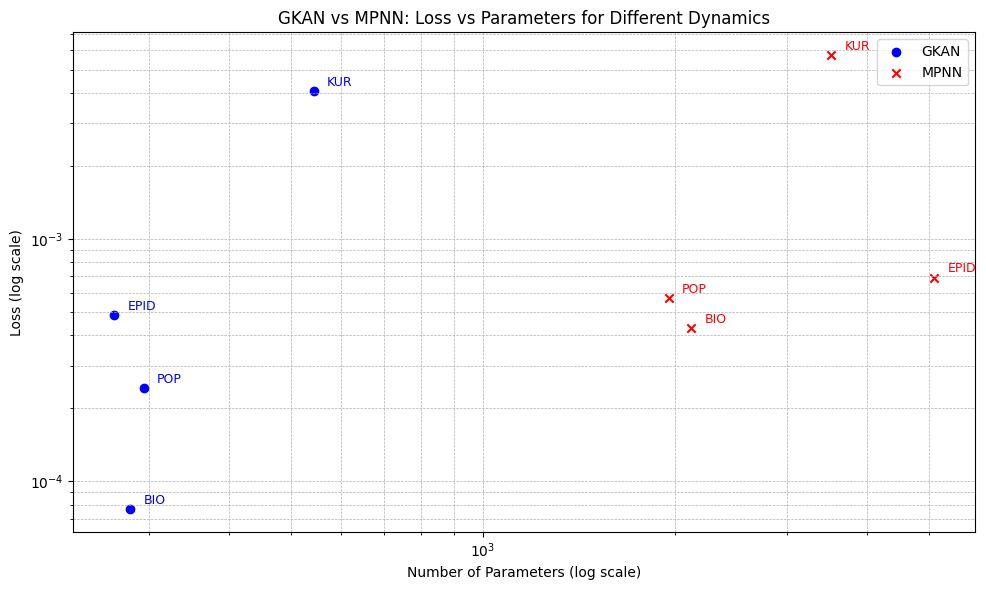

In [30]:
plt.figure(figsize=(10, 6))
for i in range(len(dynamics)):
    plt.scatter(gkan_params[i], gkan_losses[i], color='blue', label='GKAN' if i == 0 else "", marker='o')
    plt.scatter(mpnn_params[i], mpnn_losses[i], color='red', label='MPNN' if i == 0 else "", marker='x')
    plt.text(gkan_params[i]*1.05, gkan_losses[i]*1.05, dynamics[i], fontsize=9, color='blue')
    plt.text(mpnn_params[i]*1.05, mpnn_losses[i]*1.05, dynamics[i], fontsize=9, color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Parameters (log scale)')
plt.ylabel('Loss (log scale)')
plt.title('GKAN vs MPNN: Loss vs Parameters for Different Dynamics')
plt.legend()
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.tight_layout()
plt.show()